## Importing necessary libraries

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Obtaining the datasets

In [4]:
from google.colab import files 

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivaadithanbarasu","key":"49449dcad584c0b1a17645dffdafce4c"}'}

In [5]:
!pip install -q --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 3.5MB/s eta 0:00:011
kaggle.json


In [6]:
!kaggle competitions download -c dogs-vs-cats -p 'datasets'

100% 809M/812M [00:32<00:00, 17.3MB/s]
100% 812M/812M [00:32<00:00, 26.6MB/s]


In [7]:
!unzip 'datasets/dogs-vs-cats.zip' -d 'datasets' 

Archive:  datasets/dogs-vs-cats.zip
  inflating: datasets/sampleSubmission.csv  
  inflating: datasets/test1.zip      
  inflating: datasets/train.zip      


In [8]:
!unzip -q 'datasets/train.zip' -d 'datasets/trainset'
!unzip -q 'datasets/test1.zip' -d 'datasets/testset'

## Data Augmentation

Transformation steps on Training data:

- Randomly rotate images by 30 degrees.
- Randomly resize and crop images into 224x224
- Randomly flip images on their horizontal axis.
- Normalize images

Transformation steps on Test data:

- Resize images to 225x225
- Crop images in the center
- Normalize images

Batch size of 64 with 20% of training images used as validation dataset.

In [9]:
data_dir = 'datasets'

batch_size = 64

valid_size = 0.2

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(225),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/trainset', transform = train_transform)
test_data = datasets.ImageFolder(data_dir + '/testset', transform = test_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [10]:
train_data

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: datasets/trainset
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
validloader.__len__()

79

## Data Visualization

In [12]:
def img_viewer(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [13]:
def imdisp(image):
  image = image/2 + 0.5 # removing normalisation
  plt.imshow(np.transpose(image,(1,2,0))) # converting from Tensor image

torch.Size([64, 3, 224, 224])


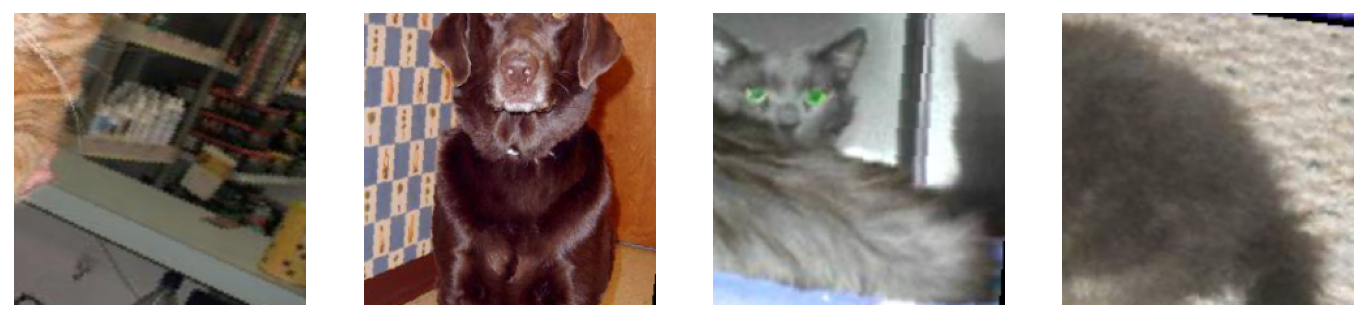

In [30]:
data_iter = iter(validloader)
images, labels = next(data_iter)
print(images.size())

fig, axes = plt.subplots(figsize=(12,6), ncols = 4)
for ii in range(4):
    ax = axes[ii]
    img_viewer(images[ii], ax=ax, normalize=True)

In [15]:
torch.cuda.current_device()

0

## Network Architeture - using Transfer Learning

I have used the densenet architecture with 121 pretrained layers.<br>
The classifier has been modified to make predictions on the given datasets. <br>
There are two fully connected layers with Relu Activation fucntion for the hidden layer and a LogSoftMax activation function for the output layer.


In [16]:
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = models.densenet121(pretrained=True)

# Freeze model parameters (in the features layers) to prevent backpropagation
for params in model.parameters():
    params.requires_grad = False
    
# Defining a custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(1024, 256)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(p=0.2)),
                                        ('fc2', nn.Linear(256,2)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [17]:
model.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

In [18]:
device

device(type='cuda', index=0)

## Training and validating the model

In [19]:
%%time
epochs = 5
valid_loss_min = np.Inf
train_losses, valid_losses = [], []

for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        
    else:
        model.eval()
        with torch.no_grad():
            for images, labels in validloader:
                images = images.to(device)
                labels = labels.to(device)
                
                logps = model.forward(images)
                loss = criterion(logps, labels)
                
                valid_loss += loss.item()*images.size(0)
        
        model.train()
        
        train_loss = train_loss/len(trainloader)
        valid_loss = valid_loss/len(validloader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(e+1, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
          print("Validation Loss has decreased from {:.6f} to {:.6f}. Saving model...".format(valid_loss_min, valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
            

Epoch: 1 	Training Loss: 0.113730 	Validation Loss: 0.000000
Validation Loss has decreased from inf to 0.000000. Saving model...
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation Loss has decreased from 0.000000 to 0.000000. Saving model...
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation Loss has decreased from 0.000000 to 0.000000. Saving model...
Epoch: 4 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation Loss has decreased from 0.000000 to 0.000000. Saving model...
Epoch: 5 	Training Loss: 0.000000 	Validation Loss: 0.000000
Validation Loss has decreased from 0.000000 to 0.000000. Saving model...
CPU times: user 19min 59s, sys: 5min 35s, total: 25min 35s
Wall time: 25min 35s


### Loading the best model

In [20]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

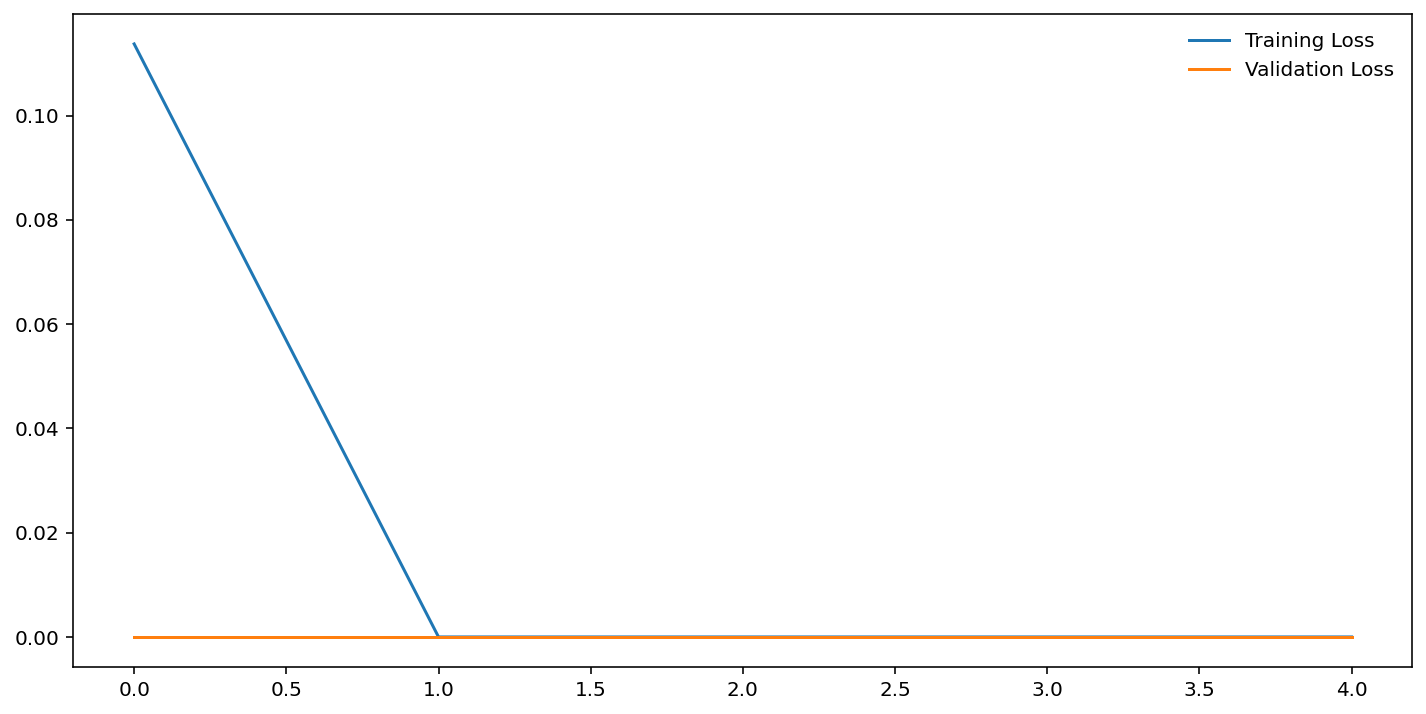

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
# plt.xticks()
plt.legend(frameon=False)
plt.show()

## Testing the model

In [26]:
test_loss = 0.0 
accuracy = 0.0

model.eval()

with torch.no_grad():
  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    logprobs = model.forward(images)
    loss = criterion(logprobs, labels)

    test_loss = loss.item()*images.size(0)

    probs = torch.exp(logprobs)
    top_p, top_class = probs.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

model.train()

test_loss = test_loss/len(testloader.sampler)

print("Test Loss: {:.6f} \tAccuracy: {:.6f}".format(test_loss, (accuracy/len(testloader))*100))




Test Loss: 0.000000 	Accuracy: 100.000000


In [28]:
def view_classify(img, ps):
    ps = ps.cpu().data.numpy().squeeze()
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.2)
    ax2.set_yticks(np.arange(2))
    ax2.set_ylabels(['Cats','Dogs'],size='small');
    ax2.set_title("Class probabilities")
    ax2.set_xlim(0,1.1)
    
    plt.tight_layout()

In [ ]:
# torch.cuda.empty_cache()